<a href="https://colab.research.google.com/github/JessicaVicentini99/fake_br_corpus_lime/blob/main/Lime_Experimento_Final_Classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00


In [2]:
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads


In [3]:
import tensorflow as tf
# from transformers import AutoTokenizer, TFAutoModelForSequenceClassification #TFBertForSequenceClassification
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel, TFAutoModelForSequenceClassification #TFBertForSequenceClassification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import os
import json
import time
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import csv
import pickle
import h5py


In [28]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


# Create Directories

In [4]:
def create_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

## Create the model path

In [6]:
def generate_model_name(models_path):
    model_folders = [f for f in os.listdir(models_path) if os.path.isdir(os.path.join(models_path, f))]
    if model_folders:
        model_folders.sort(reverse=True)
        last_model_name_parts = model_folders[0].split('_')
        if len(last_model_name_parts) >= 2:
            last_model_index = int(last_model_name_parts[0])
            model_index = last_model_index + 1
        else:
            # Handle the case where the folder name doesn't contain the expected format.
            model_index = 1
    else:
        model_index = 1

    timestamp = datetime.datetime.now().strftime('%d_%m_%Y-%H_%M')
    model_save_name = f"{model_index}_model_{timestamp}"
    return model_save_name

In [29]:
initial_base_path = '/content/drive/Shareddrives/Experimentos Propor/Models'


In [30]:
model_save_name = generate_model_name(initial_base_path)
# model_save_name = '1_model_14_09_2023-14_04'

In [31]:
base_path = initial_base_path + '/' + model_save_name
base_path

'/content/drive/Shareddrives/Experimentos Propor/Models/1_model_27_09_2023-23_25'

In [32]:
create_dir(base_path)

## dataset path

In [ ]:
# dataset_path_save = initial_base_path + '/dataset'
# dataset_path_save

In [ ]:
# create_dir(dataset_path_save)

In [33]:
def create_directories(base_path):
  directories = {
    'model_path': base_path + '/model',
    'model_without_weights': base_path + '/model_without_weights',
    'model_pretrained': base_path + '/model_save_pretrained',
    'tokenizer_pretrained': base_path + '/tokenizer_pretrained',
    'weights': base_path + '/weights',
    'checkpoints_path': base_path + '/checkpoints',
    'encoded_samples': base_path + '/encoded_samples',
    'metrics_path': base_path + '/metrics',
    'classification_report_path': base_path + '/metrics/classification_report',
    'graphs_path': base_path + '/metrics/graphs',
    'history_path': base_path + '/metrics/history',
    'lime_explanations': base_path + '/lime_explanations',
    'lime_html': base_path + '/lime_explanations/lime_html',
    'lime_html_1_1': base_path + '/lime_explanations/lime_html_1_1',
    'lime_html_0_0': base_path + '/lime_explanations/lime_html_0_0',
    'lime_html_1_0': base_path + '/lime_explanations/lime_html_1_0',
    'lime_html_0_1': base_path + '/lime_explanations/lime_html_0_1',
  }
  for name, folder_path in directories.items():
    create_dir(folder_path)
  return directories

In [ ]:
# base_path = '/content/drive/MyDrive/Arquivos/Mestrado/Qualificação/Experimentos Pos Qualificacao/Fake_Br_corpus_novo_experimento'

In [34]:
directories = create_directories(base_path)

## Geracao das pastas de metricas



In [63]:
def generate_metrics_files_name(model_name, directories):
  files_name = {
    'model': directories['model_path'] + '/' + model_name + '.h5',
    'model_without_weights': directories['model_without_weights'] + '/' + model_name + '.h5',
    # 'checkpoint': directories['checkpoints_path'] + '/' + model_name + '_checkpoint-{epoch:02d}.h5',
    'checkpoint': directories['checkpoints_path'] + '/' + model_name + '_checkpoint.h5',
    'train_encoded_samples': directories['encoded_samples'] + '/train_data_encoded_samples.h5',
    'test_encoded_samples': directories['encoded_samples'] + '/test_data_encoded_samples.h5',
    'metrics_csv': directories['metrics_path'] + '/models_metrics.csv',
    'classification_report_txt': directories['classification_report_path'] + '/' + model_name + '.txt',
    'classification_report_json': directories['classification_report_path'] + '/' + model_name + '.json',
    'graph_acc': directories['graphs_path'] + '/' + model_name + '_acc.png',
    'graph_loss': directories['graphs_path'] + '/' + model_name + '_loss.png',
    'graph_acc_and_loss': directories['graphs_path'] + '/' + model_name + '_acc_and_loss.png',
    'confusion_matrix': directories['graphs_path'] + '/' + model_name + '_confusion_matrix.png',
    'history': directories['history_path'] + '/' + model_name + '_history.json',
    'lime_explanations': directories['lime_explanations'] + '/lime_explanations.csv',
    'weights': directories['weights'] + '/weights.h5'
  }
  return files_name

In [64]:

files_name = generate_metrics_files_name(model_save_name, directories)

# Model Configs

In [37]:
MODEL_NAME = 'neuralmind/bert-base-portuguese-cased' #'bert-base-uncased'
MAX_LEN = 512
BATCH_SIZE = 24
EPOCHS = 10
LEARNING_RATE = 1e-6 #3e-5
# LEARNING_RATE = 1e-5 #3e-5
DROPOUT_RATE = 0.1

# Load Dataset



In [38]:
def load_dataset():
  dataset = pd.read_csv(
          "/content/drive/MyDrive/Arquivos/Mestrado/Qualificação/full_text_fake_br.csv",
          usecols=['label', 'content'],
          encoding='utf-8'
        )
  # print(dataset['label'].unique())
  # class_mapping = {'fake': 0, 'True': 1}
  # dataset['label'] = dataset['label'].map(class_mapping)
  return dataset

In [39]:
dataset = load_dataset()

In [40]:
dataset["label"]=dataset["label"].astype("int")

In [41]:
dataset.head()

content  label
0  Ex de Luiza Brunet é ouvido em audiência do ca...      1
1  Mercosul suspende direitos políticos da Venezu...      1
2  Relator diz que concessão de asilo a Battisti ...      1
3  Ele não precisa ser caçado, diz advogado do go...      1
4  Petrobras tem interesse em encontrar parceiros...      1

In [ ]:
dataset["label"].unique()


array([1, 0])

## Divisao Dataset

In [42]:
train,test = train_test_split(dataset,test_size=0.2,random_state=42,stratify=dataset["label"])

In [26]:
print(train.shape,test.shape)

(5760, 2) (1440, 2)


### Imprime os graficos

In [27]:
# Conte as amostras da classe 0 e da classe 1 nos conjuntos de treinamento e teste.
count_train_label_0 = (train["label"] == 0).sum()
count_train_label_1 = (train["label"] == 1).sum()

count_test_label_0 = (test["label"] == 0).sum()
count_test_label_1 = (test["label"] == 1).sum()

# Imprima as contagens.
print("Contagem da classe 0 no conjunto de treinamento:", count_train_label_0)
print("Contagem da classe 1 no conjunto de treinamento:", count_train_label_1)

print("\nContagem da classe 0 no conjunto de teste:", count_test_label_0)
print("Contagem da classe 1 no conjunto de teste:", count_test_label_1)

Contagem da classe 0 no conjunto de treinamento: 2880
Contagem da classe 1 no conjunto de treinamento: 2880

Contagem da classe 0 no conjunto de teste: 720
Contagem da classe 1 no conjunto de teste: 720


In [ ]:
train

content  label
4264  Marqueteiro do PT está inquieto na cadeia. Ele...      0
3482  População busca fósseis de dinossauros em Nova...      1
4757  CHEGA! Vitória de Trump serve de aviso para a ...      0
1942  Tribunal nega liberdade para ex-gerente de Eng...      1
327   Chuva recorde no Rio causa 4 mortes e deixa es...      1
...                                                 ...    ...
3737  Em palestra no Comando Militar da Amazônia,  P...      0
509   Caça da Marinha cai no mar do RJ; piloto está ...      1
3213  Pai de transexual relata luta contra preconcei...      1
3778  ALERTA - PT poderá transformar o Brasil em uma...      0
2447  Lula diz estar tranquilo com julgamento: Tenho...      1

[5760 rows x 2 columns]

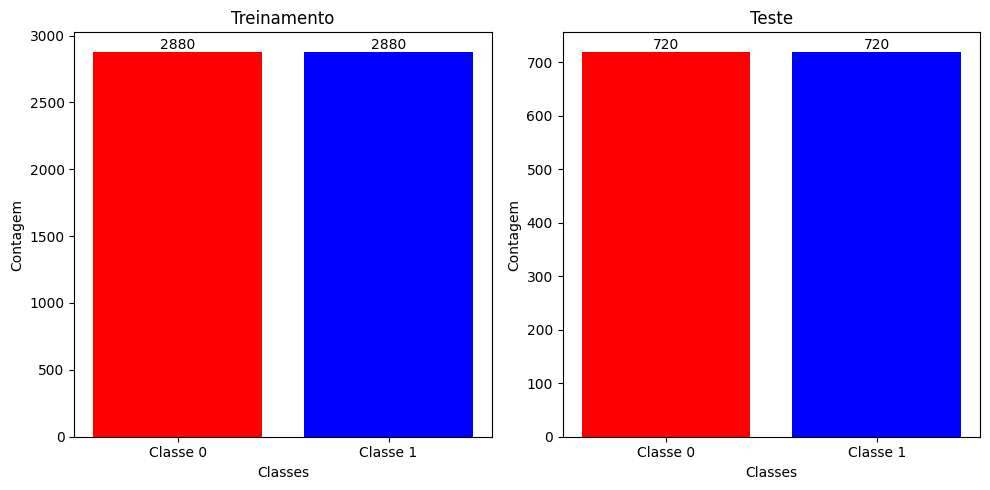

In [ ]:
import matplotlib.pyplot as plt

# Supondo que você já tenha dividido seus dados em 'train' e 'test' e tenha contado as amostras de cada classe.

# Defina as classes e as contagens para o conjunto de treinamento e teste.
classes = ['Classe 0', 'Classe 1']
train_counts = [count_train_label_0, count_train_label_1]
test_counts = [count_test_label_0, count_test_label_1]

# Crie um gráfico de barras para o conjunto de treinamento.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
bars = plt.bar(classes, train_counts, color=['red', 'blue'])
plt.title('Treinamento')
plt.xlabel('Classes')
plt.ylabel('Contagem')

# Adicione a quantidade no topo de cada barra.
for bar, count in zip(bars, train_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

# Crie um gráfico de barras para o conjunto de teste.
plt.subplot(1, 2, 2)
bars = plt.bar(classes, test_counts, color=['red', 'blue'])
plt.title('Teste')
plt.xlabel('Classes')
plt.ylabel('Contagem')

# Adicione a quantidade no topo de cada barra.
for bar, count in zip(bars, test_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.tight_layout()  # Para ajustar a posição dos gráficos.
plt.show()


## Save Dataset Train and Test

In [43]:
dataset_path_save = '/content/drive/Shareddrives/Experimentos Propor/Dataset'

In [44]:
# test_df = test.copy()
# test_df.to_csv(dataset_path_save + '/test.csv', index=False)

In [45]:
# train_df = train.copy()
# train_df.to_csv(dataset_path_save + '/train.csv', index=False)

# Load Model

In [46]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Tratamento das entradas

In [ ]:
train.head()

content  label
4264  Marqueteiro do PT está inquieto na cadeia. Ele...      0
3482  População busca fósseis de dinossauros em Nova...      1
4757  CHEGA! Vitória de Trump serve de aviso para a ...      0
1942  Tribunal nega liberdade para ex-gerente de Eng...      1
327   Chuva recorde no Rio causa 4 mortes e deixa es...      1

In [ ]:
train["content"][0]

'Ex de Luiza Brunet é ouvido em audiência do caso no qual é acusado de agressão. Lírio Parisotto é acusado de duas lesões corporais contra a modelo: em 2015 e 2016. Outras duas testemunhas, que faltaram em audiência do ano passado, também prestaram depoimento no Fórum da Barra Funda..  O empresário Lírio Parisotto foi ouvido nesta segunda-feira (13) ao Fórum Criminal da Barra Funda, na Zona Oeste de São Paulo, em nova audiência do caso no qual ele é julgado pela acusação de agredir a ex-mulher, a atriz Luiza Brunet. Parisotto não quis falar com a imprensa. A segunda audiência de instrução durou cerca de duas horas. Além do empresário, prestaram depoimento um perito e uma mulher que presenciou uma viagem do casal para o exterior. O advogado de Parisotto, Celso Vilardi, comentou o depoimento do empresário: "Ele tem uma versão só, nunca mentiu. Uma versão harmônica", disse. Ele questiona as provas apresentadas pela acusação: "Uma hora o atestado médico fala em fratura do dedo. Agora, a ac

In [48]:
tr = train["content"]
te = test["content"]

In [49]:
encoded_samples_train = tokenizer.batch_encode_plus(
    tr,
    add_special_tokens=True,  # Adicione tokens especiais como [CLS], [SEP]
    max_length=MAX_LEN,           # Defina o comprimento máximo desejado
    padding="max_length",     # Preencha/trunce para o comprimento máximo
    truncation=True,          # Truncar a sequência se exceder o comprimento máximo
    return_tensors="tf"       # Retorne tensores do PyTorch
)

In [50]:
encoded_samples_test = tokenizer.batch_encode_plus(
    te,
    add_special_tokens=True,  # Adicione tokens especiais como [CLS], [SEP]
    max_length=MAX_LEN,           # Defina o comprimento máximo desejado
    padding="max_length",     # Preencha/trunce para o comprimento máximo
    truncation=True,          # Truncar a sequência se exceder o comprimento máximo
    return_tensors="tf"       # Retorne tensores do PyTorch
)

In [51]:
# bert.save_pretrained(path_to_save)model_pretrained
tokenizer.save_pretrained(directories['tokenizer_pretrained'])

('/content/drive/Shareddrives/Experimentos Propor/Models/1_model_27_09_2023-23_25/tokenizer_pretrained/tokenizer_config.json',
 '/content/drive/Shareddrives/Experimentos Propor/Models/1_model_27_09_2023-23_25/tokenizer_pretrained/special_tokens_map.json',
 '/content/drive/Shareddrives/Experimentos Propor/Models/1_model_27_09_2023-23_25/tokenizer_pretrained/vocab.txt',
 '/content/drive/Shareddrives/Experimentos Propor/Models/1_model_27_09_2023-23_25/tokenizer_pretrained/added_tokens.json')

### save in .h5

In [52]:
# Crie um arquivo HDF5 para salvar os tensores
with h5py.File(files_name['train_encoded_samples'], 'w') as file:
    # Salve os tensores diretamente no arquivo
    file.create_dataset('input_ids', data=encoded_samples_train['input_ids'])
    file.create_dataset('attention_mask', data=encoded_samples_train['attention_mask'])
    file.create_dataset('token_type_ids', data=encoded_samples_train['token_type_ids'])

In [53]:
# Crie um arquivo HDF5 para salvar os tensores
with h5py.File(files_name['test_encoded_samples'], 'w') as file:
    # Salve os tensores diretamente no arquivo
    file.create_dataset('input_ids', data=encoded_samples_test['input_ids'])
    file.create_dataset('attention_mask', data=encoded_samples_test['attention_mask'])
    file.create_dataset('token_type_ids', data=encoded_samples_test['token_type_ids'])

# Criacao do Modelo

In [54]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
segment_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32,name="segment_ids")
bert_model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
  )
output = bert_model([input_word_ids, input_mask, segment_ids])
# output = output
# output = tf.keras.layers.Dense(32,activation='relu')(output)
# output = tf.keras.layers.Dropout(DROPOUT_RATE)(output)
logits = output.logits  # Acessa os logits da saída da camada BERT
probs = tf.keras.layers.Softmax()(logits)

# output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[probs])


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
model.compile(Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [56]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 512)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 512)]                0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1089246   ['input_word_ids[0][0]',  

# Carregar pesos do modelo

In [57]:
model.save(
    directories['model_without_weights'],
    include_optimizer=False  # Set to False to exclude optimizer state
)

In [ ]:
# model.load_weights('/content/drive/MyDrive/Propor/Experimentos/1_model_14_09_2023-14_04/checkpoints/1_model_14_09_2023-14_04_checkpoint-10.h5')


# Treinamento do Modelo

In [ ]:
# train["label"] = train["label"]

In [ ]:
# encoded_samples_train['input_ids']

In [ ]:
# input_word_ids = encoded_samples_train['input_ids']
# input_mask = encoded_samples_train['attention_mask'],
# segment_ids = encoded_samples_train['token_type_ids']

In [ ]:
# labels = np.array(train.label)

In [ ]:
# labels = labels.astype(int)  # Converte para inteiros
# labels = tf.keras.utils.to_categorical(labels, num_classes=2)


In [ ]:
# labels = labels.astype(int)  # Converte para inteiros


In [ ]:
# encoded_samples_train

In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint


In [61]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=files_name['checkpoint'],
    save_weights_only=False,  # Se True, salva apenas os pesos, se False, salva o modelo completo
    save_best_only=True,  # Salvará apenas o melhor modelo com base na métrica monitorada
    verbose=1,  # Exibe mensagens durante o salvamento do modelo
    monitor='val_loss',  # Pode monitorar métricas como 'val_loss', 'val_accuracy', etc.
    mode='min',  # Pode ser 'min' ou 'max', dependendo da métrica monitorada
)

In [62]:
start_time = time.time()

# checkpoint = ModelCheckpoint(files_name['checkpoint'], save_freq='epoch')

history = model.fit(
          x={
              "input_word_ids": encoded_samples_train["input_ids"],
              "input_mask": encoded_samples_train["attention_mask"],
              "segment_ids": encoded_samples_train["token_type_ids"]
          },
          y=train['label'],
          validation_split=0.20,
          epochs = EPOCHS,
          batch_size = BATCH_SIZE,
          callbacks=[model_checkpoint_callback]
          )
end_time = time.time()


Epoch 1/10
192/192 [==============================] - ETA: 0s - loss: 0.5604 - accuracy: 0.3092
Epoch 1: val_loss improved from inf to 0.32937, saving model to /content/drive/Shareddrives/Experimentos Propor/Models/1_model_27_09_2023-23_25/checkpoints/1_model_27_09_2023-23_25_checkpoint-01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


192/192 [==============================] - 122s 433ms/step - loss: 0.5604 - accuracy: 0.3092 - val_loss: 0.3294 - val_accuracy: 0.4783
Epoch 2/10
192/192 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.4911
Epoch 2: val_loss improved from 0.32937 to 0.11179, saving model to /content/drive/Shareddrives/Experimentos Propor/Models/1_model_27_09_2023-23_25/checkpoints/1_model_27_09_2023-23_25_checkpoint-02.h5
192/192 [==============================] - 78s 406ms/step - loss: 0.1959 - accuracy: 0.4911 - val_loss: 0.1118 - val_accuracy: 0.5009
Epoch 3/10
192/192 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.4946
Epoch 3: val_loss improved from 0.11179 to 0.07985, saving model to /content/drive/Shareddrives/Experimentos Propor/Models/1_model_27_09_2023-23_25/checkpoints/1_model_27_09_2023-23_25_checkpoint-03.h5
192/192 [==============================] - 78s 409ms/step - loss: 0.0880 - accuracy: 0.4946 - val_loss: 0.0798 - val_accuracy: 0.5009
E

https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained#8.-BERT

In [65]:
model.save(
    directories['model_path']
)

In [66]:
model.save_weights(
    files_name['weights']
)


In [67]:
# model.save_pretrained(directories['model_pretrained'])


AttributeError: ignored

# Avaliação do modelo

## Excucao do modelo no conjunto de testes

In [68]:
test["label"] = test["label"].astype(float)

In [69]:
test_loss, test_acc = model.evaluate( x={
              "input_word_ids": encoded_samples_test["input_ids"],
              "input_mask": encoded_samples_test["attention_mask"],
              "segment_ids": encoded_samples_test["token_type_ids"]
          },
          y=test['label'])


45/45 [==============================] - 8s 125ms/step - loss: 0.0562 - accuracy: 0.4972


In [ ]:
# threshold = 0.5


In [ ]:
# y_pred = model.predict([ids_test, masks_test, segments_test])

# y_pred_bool = np.argmax(y_pred, axis=1)


# Geração de Relatorios

In [70]:
y_pred = model.predict( x={
              "input_word_ids": encoded_samples_test["input_ids"],
              "input_mask": encoded_samples_test["attention_mask"],
              "segment_ids": encoded_samples_test["token_type_ids"]
          })
y_pred_bool = np.argmax(y_pred, axis=1)

45/45 [==============================] - 7s 123ms/step


In [71]:
y_pred_bool

array([0, 0, 0, ..., 1, 1, 1])

In [72]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class')
  return hmap

In [77]:
def generate_classification_report(y_pred, y_pred_bool, test, files_name):
  report = classification_report(y_pred_bool, test["label"])
  report_dict = classification_report(y_pred_bool, test["label"], output_dict=True)
  df_report = pd.DataFrame(report_dict).transpose()

  with open(files_name['classification_report_json'], 'w') as f:
    json.dump(report_dict, f)

  with open(files_name['classification_report_txt'], 'w') as f:
    f.write(report)

  print(report)

  # CLASSIFICATION REPORT
  cm = confusion_matrix(test["label"], y_pred_bool)
  df_cm = pd.DataFrame(cm, index=['0','1'], columns=['0','1'])
  heatmap = show_confusion_matrix(df_cm)
  heatmap.figure.savefig(files_name['confusion_matrix'])


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       716
           1       0.99      0.98      0.99       724

    accuracy                           0.99      1440
   macro avg       0.99      0.99      0.99      1440
weighted avg       0.99      0.99      0.99      1440



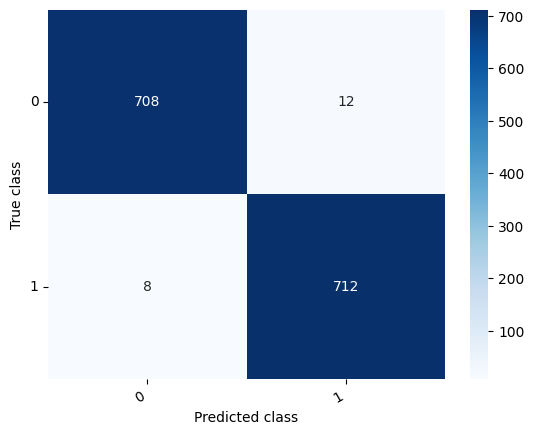

In [74]:
generate_classification_report(y_pred, y_pred_bool, test, files_name)

# Salvar metricas do modelo

In [79]:
def save_model_metrics(model_save_name, files_name, start_time,
                       end_time, epochs, batch_size, learning_rate, dropout,
                       test_loss, test_acc, with_stop_words):
  # Calcula o tempo de execução em segundos
  time_seconds = round(end_time - start_time, 2)

  # Calcula o tempo de execução em minutos
  time_minutes = round(time_seconds / 60, 2)
  metrics = {
    'model': model_save_name,
    'loss': history.history['loss'][-1],
    'accuracy': history.history['accuracy'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_accuracy': history.history['val_accuracy'][-1],
    'time': str(end_time - start_time),
    'time_seconds': time_seconds,
    'time_minutes': time_minutes,
    'epochs': epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'dropout': dropout,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'with_stop_words': with_stop_words
  }

  if os.path.isfile(files_name['metrics_csv']):
      # Se o arquivo existe, leia-o em um DataFrame
      df_metrics = pd.read_csv(files_name['metrics_csv'])
  else:
      # Se o arquivo não existe, crie um DataFrame vazio
      df_metrics = pd.DataFrame()

  df_metrics = df_metrics.append(metrics, ignore_index=True)
  df_metrics.to_csv(files_name['metrics_csv'], index=False)

  with open(files_name['history'], 'w') as f:
    json.dump(history.history, f)

  display(df_metrics.tail())



In [80]:
save_model_metrics(model_save_name, files_name, start_time, end_time,
                   EPOCHS, BATCH_SIZE, LEARNING_RATE, DROPOUT_RATE, test_loss,test_acc, True)


<ipython-input-79-d5ef79ada09a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(metrics, ignore_index=True)


model      loss  accuracy  val_loss  val_accuracy  \
0  1_model_27_09_2023-23_25  0.010814  0.496528  0.032549      0.506944   

                time  time_seconds  time_minutes  epochs  batch_size  \
0  760.8303966522217        760.83         12.68      10          24   

   learning_rate  dropout  test_loss  test_acc  with_stop_words  
0       0.000001      0.1   0.056194  0.497222             True

# Separacao das 40 amostras

## Salvando todas as amostras de teste e sua predicao

In [98]:
all_samples_path = '/content/drive/Shareddrives/Experimentos Propor/Dataset/all_samples.csv'
selected_samples_path = '/content/drive/Shareddrives/Experimentos Propor/Dataset/selected_samples.csv'

In [84]:
y_pred_bool

array([0, 0, 0, ..., 1, 1, 1])

In [86]:
result_df = pd.DataFrame({
    'content': test['content'],
    'real_label': test['label'],
    'predicted_label': y_pred_bool
})

In [87]:
result_df.to_csv(all_samples_path, index=True)  # O argumento 'index=False' evita que o índice seja salvo no arquivo CSV


## Salvando as 40 amostras do experimento

In [88]:
import random

In [90]:
# Carregue o CSV original
original_df = pd.read_csv(all_samples_path)

In [91]:
# Selecione aleatoriamente 5 amostras da classe 0 classificadas como 0
class_0_as_0 = original_df[(original_df['real_label'] == 0) & (original_df['predicted_label'] == 0)].sample(5)

# Selecione aleatoriamente 5 amostras da classe 0 classificadas como 1
class_0_as_1 = original_df[(original_df['real_label'] == 0) & (original_df['predicted_label'] == 1)].sample(5)

# Selecione aleatoriamente 5 amostras da classe 1 classificadas como 1
class_1_as_1 = original_df[(original_df['real_label'] == 1) & (original_df['predicted_label'] == 1)].sample(5)

# Selecione aleatoriamente 5 amostras da classe 1 classificadas como 0
class_1_as_0 = original_df[(original_df['real_label'] == 1) & (original_df['predicted_label'] == 0)].sample(5)

In [92]:
# Combine as amostras selecionadas
selected_samples = pd.concat([class_0_as_0, class_0_as_1, class_1_as_1, class_1_as_0])

In [94]:
# Selecione aleatoriamente mais 20 amostras que não estejam nas amostras selecionadas anteriormente
remaining_samples = original_df[~original_df.index.isin(selected_samples.index)].sample(20)

In [96]:
# Combine as amostras selecionadas e as amostras restantes
final_samples = pd.concat([selected_samples, remaining_samples])

In [99]:
# Salve o novo DataFrame em um arquivo CSV
final_samples.to_csv(selected_samples_path, index=True)

# salvar grafico do treinamento

In [81]:
def save_model_graphs(model_save_name, files_name, history):
  epochs_range = list(range(1, len(history.history['accuracy'])+1))
  # cria o gráfico de Accuracy
  plt.plot(epochs_range, history.history['accuracy'])
  plt.plot(epochs_range, history.history['val_accuracy'])
  plt.title('Training and Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')

  # Salva figura
  plt.savefig(files_name['graph_acc'])
  plt.show()

  # cria o gráfico de Loss
  plt.plot(epochs_range, history.history['loss'])
  plt.plot(epochs_range, history.history['val_loss'])
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')

  # Salva figura
  plt.savefig(files_name['graph_loss'])
  plt.show()

  # Definir o tamanho da figura
  fig, axs = plt.subplots(1, 2, figsize=(15,5))

  # Plotar o gráfico de loss no primeiro subplot
  axs[0].plot(epochs_range, history.history['loss'], label='train_loss')
  axs[0].plot(epochs_range, history.history['val_loss'], label='val_loss')
  axs[0].set_title('Model Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()

  # Plotar o gráfico de acurácia no segundo subplot
  axs[1].plot(epochs_range, history.history['accuracy'], label='train_acc')
  axs[1].plot(epochs_range, history.history['val_accuracy'], label='val_acc')
  axs[1].set_title('Model Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()

  # Salvar a figura em um arquivo
  plt.savefig(files_name['graph_acc_and_loss'])

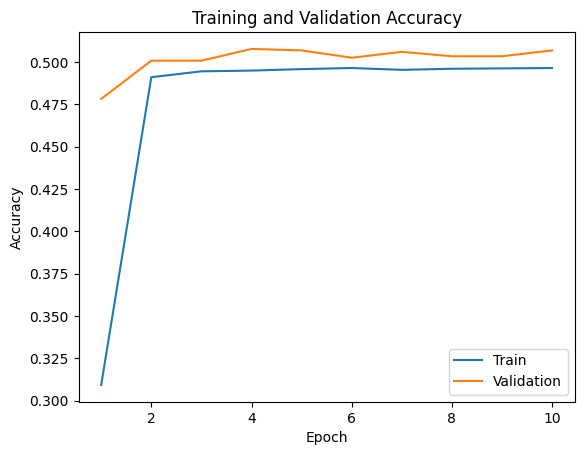

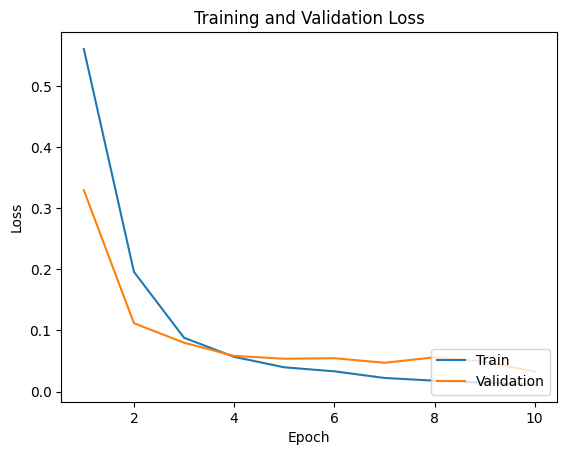

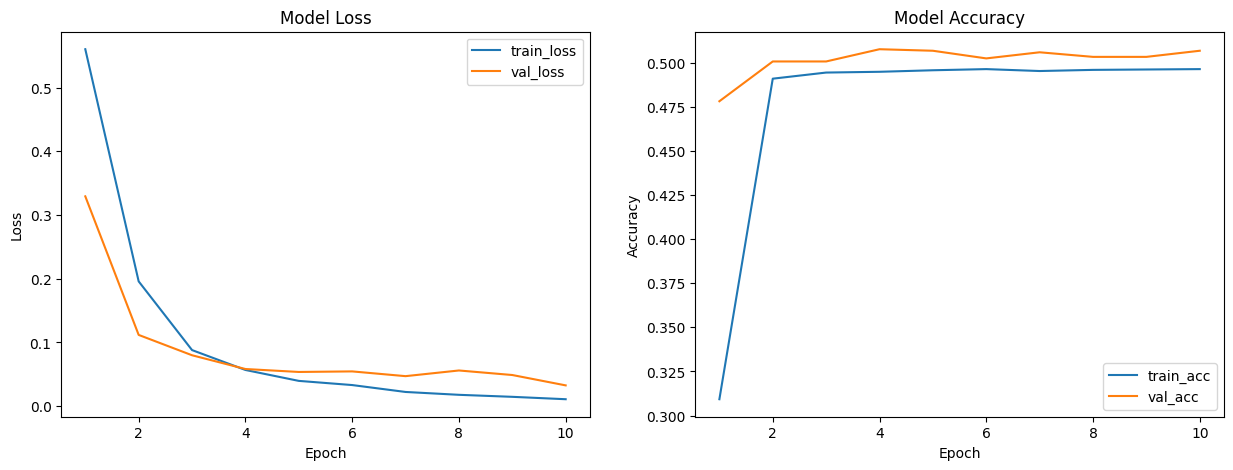

In [82]:
save_model_graphs(model_save_name, files_name, history)

In [ ]:
# np.shape(ids_test)

In [ ]:
# y_pred

In [ ]:
# # y_pred_bool = np.where(y_pred >= threshold, 1, 0)
# y_pred_bool = np.argmax(y_pred, axis=1)
# from sklearn.metrics import classification_report

# print(classification_report(y_pred_bool, test["label"]))

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns


In [ ]:
# np.shape(y_pred_bool)

# LIME

https://www.kaggle.com/code/arinjaypathak/fine-tuned-bert-lime-youtube-comment-sentiment

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=93ab5b664abca093f4439f40ef8a1600580d0b18333871ba8903246361f2f436
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
from lime.lime_text import LimeTextExplainer

## LimeTestes

## Funçao de predicao

In [ ]:
def predict_proba(arr):
    # processed=[]
    # for i in arr:
    #     processed.append(i)
    # id,segment,mask=prepare(arr,tokenizer,max_length=200)
    encoded_sample = tokenizer.batch_encode_plus(
        arr,
        add_special_tokens=True,  # Adicione tokens especiais como [CLS], [SEP]
        max_length=MAX_LEN,           # Defina o comprimento máximo desejado
        padding="max_length",     # Preencha/trunce para o comprimento máximo
        truncation=True,          # Truncar a sequência se exceder o comprimento máximo
        return_tensors="tf"       # Retorne tensores do PyTorch
    )
    pred=model.predict(x={
              "input_word_ids": encoded_sample["input_ids"],
              "input_mask": encoded_sample["attention_mask"],
              "segment_ids": encoded_sample["token_type_ids"]
          })
    return pred
    # id, segment, mask = prepare([arr], tokenizer, max_length=200)
    # pred = model.predict([id, mask, segment], batch_size=1)
    # return pred

In [ ]:
def save_lime_explain(model_save_name, files_name, pos, sample_index, sample_text, original_class, prediction_class):

  metrics = {
    'model_name': model_save_name,
    'pos': pos,
    'index': sample_index,
    'real_class': original_class,
    'pred_class': prediction_class,
    'text': sample_text
  }

  if os.path.isfile(files_name['lime_explanations']):
      # Se o arquivo existe, leia-o em um DataFrame
      df_lime = pd.read_csv(files_name['lime_explanations'])
  else:
      # Se o arquivo não existe, crie um DataFrame vazio
      df_lime = pd.DataFrame()

  df_lime = df_lime.append(metrics, ignore_index=True)
  df_lime.to_csv(files_name['lime_explanations'], index=False)
  display(df_lime.tail())


In [ ]:
def explain_instance(directories, test, y_pred_bool, model_save_name, files_name):
  class_names = [0, 1]
  explainer = LimeTextExplainer(class_names=class_names)
  i = 0
  for index, row in test.iterrows():
    if i <= 682:
      i = i + 1
      continue
    file_name = '/' + model_save_name + '_' + str(i) + '_pos_' + str(index) + '_index_'+ str(int(row['label'])) + '_orig_class_'+ str(y_pred_bool[i]) +'pred_class__lime_explain'
    html_path = 'lime_html_' +  str(int(row['label'])) + '_' + str(y_pred_bool[i])
    # explicando instancia
    exp = explainer.explain_instance(row['content'], predict_proba)
    exp.show_in_notebook(text=True)
    # Salvando html do lime
    exp.save_to_file(directories[html_path] + file_name + '.html')
    # salvando explicancao como csv
    result_list = exp.as_list()
    csv_file_name = directories[html_path] + file_name + '.csv'
    with open(csv_file_name, mode='w', newline='') as result_file:
      writer = csv.writer(result_file)
      writer.writerows(result_list)
    # salvando texto e predicao e classe real no csv com todas as amostras
    save_lime_explain(model_save_name, files_name, i, index, row['content'], row['label'], y_pred_bool[i])
    i = i + 1
    print(i)
    print('-------------------------------------')


In [ ]:
explain_instance(directories, test, y_pred_bool, model_save_name, files_name)

157/157 [==============================] - 1691s 11s/step


<ipython-input-59-dcf84bfed7e6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lime = df_lime.append(metrics, ignore_index=True)


model_name  pos  index  real_class  pred_class  \
0  1_model_14_09_2023-14_04  683   2964         1.0           1   

                                                text  
0  Homem é flagrado pegando dinheiro de caixinha ...

684
-------------------------------------
157/157 [==============================] - 1688s 11s/step


<ipython-input-59-dcf84bfed7e6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lime = df_lime.append(metrics, ignore_index=True)


model_name  pos  index  real_class  pred_class  \
0  1_model_14_09_2023-14_04  683   2964         1.0           1   
1  1_model_14_09_2023-14_04  684   5917         0.0           0   

                                                text  
0  Homem é flagrado pegando dinheiro de caixinha ...  
1  Com medo de ser preso,  Lula recorre aos "Dire...

685
-------------------------------------
157/157 [==============================] - 1680s 11s/step


<ipython-input-59-dcf84bfed7e6>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lime = df_lime.append(metrics, ignore_index=True)


model_name  pos  index  real_class  pred_class  \
0  1_model_14_09_2023-14_04  683   2964         1.0           1   
1  1_model_14_09_2023-14_04  684   5917         0.0           0   
2  1_model_14_09_2023-14_04  685   6934         0.0           0   

                                                text  
0  Homem é flagrado pegando dinheiro de caixinha ...  
1  Com medo de ser preso,  Lula recorre aos "Dire...  
2  Cientistas testemunham as origens de ouro atra...

686
-------------------------------------
107/157 [===================>..........] - ETA: 8:58

KeyboardInterrupt: ignored

In [ ]:
def explain_instance(explainer, directories, test):


# experimentos de teste Lime

In [ ]:
# y_pred = model.predict([ids_test, masks_test, segments_test])
# row_index = dataset.loc[dataset['label'] == 0].index[0]
# row = dataset.loc[row_index, :]
# ids_train, segments_train, masks_train = prepare(tr,
#                                                  tokenizer, MAX_LEN)

## funcao de predicao

In [ ]:
def predict_proba_test(arr):
    # processed=[]
    # for i in arr:
    #     processed.append(i)
    id,segment,mask=prepare(arr,tokenizer,max_length=200)
    pred=model.predict([id,mask,segment])
    return pred
    # id, segment, mask = prepare([arr], tokenizer, max_length=200)
    # pred = model.predict([id, mask, segment], batch_size=1)
    # return pred

In [ ]:
row_index

In [ ]:
dataset.iloc[4,:]

In [ ]:
# sample_text = dataset.iloc[4,:]
sample_text = dataset['content'][4]
sample_text = dataset['content'][4]
      # dataset['content'][3600]

samples = [
     dataset['content'][4],
     dataset['content'][3600]
]

In [ ]:
samples = [
     dataset['content'][6660],
]

In [ ]:
dataset.iloc[3600,:]

In [ ]:
test['content'][6660]

In [ ]:
test["label"]

In [ ]:
resp = predict_proba_test(samples)

In [ ]:
resp

In [ ]:
resp

In [ ]:
resp = predict_proba(dataset['content'][4])

In [ ]:
# test = np.where(resp >= threshold, 1, 0)
np.argmax(resp, axis=0)

## instanciando explainer

In [ ]:
class_names = [0, 1]
explainer = LimeTextExplainer(class_names=class_names)


In [ ]:
explainer.explain_instance(dataset['content'][3600],predict_proba).show_in_notebook(text=True)


In [ ]:
explainer.explain_instance(dataset['content'][4],predict_proba).show_in_notebook(text=True)
